In [ ]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools
import glob 
from PIL import Image
import csv 
import cv2
import re
from torchvision.transforms import functional as F
from torchvision.ops.boxes import box_iou
import random
import torchvision
import warnings

!pip install --upgrade albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
%cd Ranger-Deep-Learning-Optimizer
!pip install -e .
from ranger import Ranger  
%cd ..
#https://paperswithcode.com/paper/sharpness-aware-minimization-for-efficiently-1
!git clone https://github.com/davda54/sam.git
%cd sam
import sam
print("Imported SAM Successfully from github .py file")
%cd ..


def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed = 42)

In [2]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)

Mounted at /content/drive/


## To Do Right Now: 

### Steps for fully integrating effecient det 
* Update this code to run on a single image in a train batch
* change run metrics for batch so it can understand how effdet outputs data and then develops statistics.
* Make a validation loader
* Play with test function using optimization techniues like Normalizing (ensuring normalizing is consistent and global), sam, ranger to see if that increase acc or decreases loss

later: 
* Understand Effecient Det Data Parralel code


### Spend 2 hours labeling the other data on peaches and tomatoes label them and put them in dataset.


### Email Evan about any new project ideas. Look at new project ideas from the DOCUMENT. Read about new ideas into agriculture and look for problems that can be solved with computer vision. Also, develop note-taking idea a little bit. 

#Possible Solution

### go to ImageNet and get images of round classes so like human faces or dog faces or balls etc. (have no bounding boxes). Get a new loader called noise_loader and make a loss that sees how many bouding boxes are predicted in the noise_loader class.

# Goal 
Get model running on web cam on like 10 different fruits / vegetables

#Less Urgent Ideas in the Future:

### Look into turning jupyter notebook into python script or deploy it to rasberry pi. Makes sure when converting to python script be aware of classes variable.

 
### https://www.emerginginvestigators.org/articles?category_id=10

### Train, Once I get a model with very good results. torch.save it state_dicts on my local disk. Also record results of models on results spreadsheet.



In [3]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/LatestFruit Defects Dataset .zip", 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile("/content/drive/MyDrive/EfficientDet.Pytorch-Updated.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
import torch.backends.cudnn as cudnn


%cd EfficientDet.Pytorch-Updated/
import math
from models.efficientnet import EfficientNet
from models.bifpn import BIFPN
from models.retinahead import RetinaHead
from models.module import RegressionModel, ClassificationModel, Anchors, ClipBoxes, BBoxTransform
from torchvision.ops import nms
from models.losses import FocalLoss
from models.efficientdet import EfficientDet
from models.losses import FocalLoss
from datasets import VOCDetection, CocoDataset, get_augumentation, detection_collate, Resizer, Normalizer, Augmenter, collater
from utils import EFFICIENTDET, get_state_dict
from eval import evaluate, evaluate_coco
%cd ..

/content/EfficientDet.Pytorch-Updated
/content


In [5]:
#For one strawberry batch please drop watermark rows
strawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 3 Labeled/FreshStrawberryBatch3Labels.csv", header = None)
strawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 2 Labeled/FreshStrawberriesBatch2Labels.csv", header = None)
strawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/Strawberrybatch1.csv", header = None)
rottenApple_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch1Labeled/RottenAppleBatch1Labels.csv", header = None)
rottenApple_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApplesBatch2Labels.csv", header = None)
rottenApple_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch3Labaled/RottenApplesBatch3Labels.csv", header = None)
rottenStrawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch1RottenStrawBerryLabels/RottenStrawberriesBatch1Labels.csv", header = None)
rottenStrawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch2RottenStrawBerryLabels/RottenStrawBerryBatch2.csv", header = None)
rottenStrawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch3RottenStrawberrylabel/rottenStrawberryBtch3labels.csv", header = None)
freshApples_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshApples/FreshApplebtch2label/FreshApplesBatch2LabelsFresh.csv", header = None)
freshApples_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshApples/FreshApplesBatch1Labels/FreshAppleBatch1Labels.csv", header = None)
rottenTomato_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/Rotten Tomatoes/Rotten TomatoBatch1/Batch1TomoatosLabelsBbox.csv", header = None)
rottenTomato_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/Rotten Tomatoes/RottnTomatoBatch2/RottenTomatyoBatch2Labelss.csv", header = None)
rottenTomato_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/Rotten Tomatoes/RottenTomatBtch3/RottenTomatoesBatch3Labssles.csv", header = None)
rottenTomato_csv_batch_4 = pd.read_csv("/content/Fruit Defects Dataset /Train/Rotten Tomatoes/RottenTomatoesBatch4/Tomatobatch4labelssRotten.csv", header = None)
freshTomato_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/Fresh Tomatoes/FreshTomatoesBatch1Labelss/FreshTomatoesLabelsBatch1Labels.csv", header = None)
freshTomato_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/Fresh Tomatoes/FreshTomatBatch2Labessls/Batch2TomatlabelsFresh.csv", header = None)

strawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshApples_csv_batch_2.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshApples_csv_batch_1.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenTomato_csv_batch_1.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenTomato_csv_batch_2.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenTomato_csv_batch_3.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenTomato_csv_batch_4.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshTomato_csv_batch_1.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshTomato_csv_batch_2.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]

#Drop some watermark data for Fresh StrawBerry Batch 1 Labeled images [59, 9, 93]

# strawberry_csv_batch_1 = strawberry_csv_batch_1[Image_id not in ["FreshStrawberries59.jpeg, FreshStrawberries9.jpeg, FreshStrawberries93.jpeg"]]
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries59.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries9.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries93.jpeg"].index, inplace = True)
freshTomato_csv_batch_1.drop(freshTomato_csv_batch_1[freshTomato_csv_batch_1["Image_id"] == "Fresh Tomatoes66AddonPart1.jpeg"].index, inplace = True)

strawberry_csv_batch_1 = strawberry_csv_batch_1.reset_index(drop=True)
freshTomato_csv_batch_1 = freshTomato_csv_batch_1.reset_index(drop = True)

#Stack all the csv files together. 
list_of_all_dataframes = [strawberry_csv_batch_1, strawberry_csv_batch_2, strawberry_csv_batch_3, rottenApple_csv_batch_1, 
                          rottenApple_csv_batch_2, rottenApple_csv_batch_3, rottenStrawberry_csv_batch_1, rottenStrawberry_csv_batch_2, 
                          rottenStrawberry_csv_batch_3, freshApples_csv_batch_2, freshApples_csv_batch_1, rottenTomato_csv_batch_1, 
                          rottenTomato_csv_batch_2, rottenTomato_csv_batch_3, rottenTomato_csv_batch_4, freshTomato_csv_batch_1, 
                          freshTomato_csv_batch_2]
fruit_df = pd.concat(list_of_all_dataframes, ignore_index = True)

total_row_sum_check = 0 
for dataframe in list_of_all_dataframes:
  total_row_sum_check += dataframe.shape[0]
print("Checked total rows from all the dataframes combined: {}".format(total_row_sum_check))

def run_dataframe_check():
  assert total_row_sum_check == fruit_df.shape[0]
  print("DataFrame shape: {}".format(fruit_df.shape))
  print("Unique Fruit Labels {}".format(fruit_df["Fruit"].unique()))
  print("Number of Unique Images {}".format(len(fruit_df["Image_id"].unique())))

run_dataframe_check()

Checked total rows from all the dataframes combined: 1882
DataFrame shape: (1882, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Bad_Spots' 'Tomato']
Number of Unique Images 532


In [6]:
#Specify more image types when 
def more_specific_Image_id(image_id, fruit):
  if fruit == "Bad_Spots":
    if re.search("RottenStrawberries", image_id):
      return "Strawberry_Bad_Spot"
    elif re.search("RottenApples", image_id):
      return "Apple_Bad_Spot"
    elif re.search("Rotten Tomatoes", image_id):
      return "Tomato_Bad_Spot"
    else:
      raise ValueError("Could not find a match for some of the Image_ids")

  else:
    return fruit

fruit_df["Fruit"] = fruit_df.apply(lambda row: more_specific_Image_id(row.Image_id, row.Fruit), axis = 1)

run_dataframe_check()

#Post Processing 
fruit_df = fruit_df[fruit_df["Image_id"] != "FreshStrawberries15.jpeg"]

DataFrame shape: (1882, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Apple_Bad_Spot' 'Strawberry_Bad_Spot' 'Tomato'
 'Tomato_Bad_Spot']
Number of Unique Images 532


In [7]:
bounding_box_dict = dict()
labels_dict = dict()
classes = ["Placeholder", "Apples", "Strawberry", "Tomato", "Apple_Bad_Spot", "Strawberry_Bad_Spot", "Tomato_Bad_Spot"]
# classes = ["Apples", "Strawberry", "Apple_Bad_Spot", "Strawberry_Bad_Spot"]
print(classes)
# classes = ["Bad_Spots", "Strawberry", "Apples"]

for row_index in range(len(fruit_df)): 
  current_image_file = fruit_df.iloc[row_index]["Image_id"]
  if current_image_file not in bounding_box_dict:
    bounding_box_dict[current_image_file] = list()
    labels_dict[current_image_file] = list()
  bounding_box_dict[current_image_file].append(fruit_df.iloc[row_index, 1:5].to_list())
  labels_dict[current_image_file].append(classes.index(fruit_df.iloc[row_index, 0]))

print(len(bounding_box_dict))
print(len(labels_dict))

['Placeholder', 'Apples', 'Strawberry', 'Tomato', 'Apple_Bad_Spot', 'Strawberry_Bad_Spot', 'Tomato_Bad_Spot']
531
531


## Class function + util functions

In [8]:
def ffile_path(image_id, full_image_file_paths):
  for image_path in full_image_file_paths:
    if image_id in image_path:
      return image_path

def find_area_bb(bb_coord):
  bb_coord = bb_coord.numpy()
  area_of_each_bb = list()
  for pair_of_coord in bb_coord:
    area_of_each_bb.append(
        (pair_of_coord[2] - pair_of_coord[0]) * (pair_of_coord[3] - pair_of_coord[1])
    )
  return torch.tensor(area_of_each_bb, dtype=torch.int32)

def convert_min_max(bb_coord):
  for pair_of_coord in bb_coord:
    pair_of_coord[2], pair_of_coord[3] = (pair_of_coord[0] + pair_of_coord[-2]), (pair_of_coord[1] + pair_of_coord[-1])
  return bb_coord

class FruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms, mode):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())

    np.random.shuffle(self.imgs_key)
    if (mode == "train"):
      self.imgs_key = self.imgs_key[:int(len(self.imgs_key) * 0.8)]
    else:
      self.imgs_key = self.imgs_key[int(len(self.imgs_key) * 0.8):]

    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms

  def __getitem__(self, idx):

    img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths) 
    img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    boxes = convert_min_max(torch.as_tensor(self.id_bounding_boxes[self.imgs_key[idx]], dtype=torch.float32))
    
    labels = torch.as_tensor(self.id_labels[self.imgs_key[idx]], dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = find_area_bb(boxes)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    
    #Query about transforms for labels of images
    if self.transforms: 
      sample = {
                'image': img,
                'bboxes': target['boxes'],
                'labels': labels
            }

      sample = self.transforms(**sample)
      img = sample['image']
      target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
    
    
    return img, target

  def __len__(self):
    return len(self.imgs_key)

In [9]:
#The Drawing function.
# COLORS = [(255, 0, 0), (0, 255, 0), (0, 0 , 255), (255, 255, 0)]
COLORS = [(0, 0, 0), (0, 255, 0), (0, 0 , 255), (255, 255, 0), (255, 0, 0)]

def draw_boxes(boxes, labels, image, infer = False, put_text = True):
    # read the image with OpenCV
    image = image.permute(1, 2, 0).numpy()
    if infer:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i] % len(COLORS)]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        if put_text:
          cv2.putText(image, classes[labels[i]], (int(box[0]), int(box[1]-5)),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                      lineType=cv2.LINE_AA)
    return image

# Albumentations
def get_transforms(mode):
  if (mode == "train"):
    return A.Compose([
                      A.OneOf([
                      A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9)],p=0.9),
                      A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, p=0.5),
                      A.HorizontalFlip(),
                      A.VerticalFlip(), 
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  elif (mode == "test"):
    return A.Compose([
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  elif (mode == "effdet_train"):
    return A.Compose([
                      A.OneOf([
                      A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9)],p=0.9),
                      A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, p=0.5),
                      A.HorizontalFlip(),
                      A.VerticalFlip(), 
                      A.Resize(height = 512, width=512), 
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

  else:
    raise ValueError("mode is wrong value can either be train or test")

#Using this stack overflow (https://stackoverflow.com/questions/65279115/how-to-use-collate-fn-with-dataloaders)
#(Suppose for example, you want to create batches of a list of varying dimension tensors. The below code pads sequences with 0 until the maximum sequence size of the batch,)
#Collate_fn is a function that is used to process your batches before you pass it to dataloader. In my case since I have different sized images I need a way to stack batches b/c torch.stack won't work.
#So I use zip which can accept tensors of different lengths and make them stacked with the size of the lowest length list given. Therefore stacking all the images in a batch 
#Successfully unlike torch.stack and doing that processing to every batch makes collate_fn vital since I have different image sizes.

def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])
    # return tuple(zip(*batch))

train_batch_size = 1
test_batch_size = 1

train_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transforms(mode = "train"), mode = "train")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, collate_fn= collate_fn)

test_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transforms(mode = "test"), mode = "test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = test_batch_size, shuffle = True, collate_fn= collate_fn)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

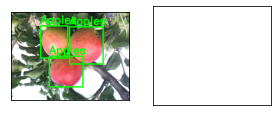

In [10]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx])
    plt.imshow(image)

## What we learned
is that the model outputs losses when in train mode 
when in model.eval model, the model code then return only a prediction with no losses.

In [88]:
def calculate_metrics(target_box,predictions_box,scores, device):

    #Get most confident boxes first and least confident last
    predictions_box = predictions_box[scores.argsort().flip(-1)]
    iou_mat = box_iou(target_box,predictions_box)
    #return a one by one matrix that is form (target_box, prediction_box) or (1, 1)
    target_boxes_count, prediction_boxes_count = iou_mat.shape
    
    mAP_Matrix = torch.zeros_like(iou_mat)
    # if not matrix coordinates that relate to nothing.
    if not iou_mat[:,0].eq(0.).all():
      index_of_biggest_iou = iou_mat[:,0].argsort()[-1]
      mAP_Matrix[index_of_biggest_iou,0] = 1

    for pr_idx in range(1,prediction_boxes_count):
        not_assigned = torch.logical_not(mAP_Matrix[:,:pr_idx].sum(1)).long()
        targets = not_assigned * iou_mat[:,pr_idx]

        if targets.eq(0).all():
            continue

        pivot = targets.argsort()[-1]
        mAP_Matrix[pivot,pr_idx] = 1

    # mAP calculation
    tp = mAP_Matrix.sum()
    fp = mAP_Matrix.sum(0).eq(0).sum()
    fn = mAP_Matrix.sum(1).eq(0).sum()

    mAP = tp / (tp+fp)
    mAR = tp / (tp+fn)

    return mAP, mAR

def run_metrics_for_batch(output, targets, mAP, mAR, missed_images, device):
  for pos_in_batch, image_pred in enumerate(output):
    assert (len(image_pred["boxes"]) == len(image_pred["labels"]) == len(image_pred["scores"]))
    if len(image_pred["boxes"]) != 0:
      curr_mAP, curr_mAR = calculate_metrics(targets[pos_in_batch]["boxes"], output[pos_in_batch]["boxes"], output[pos_in_batch]["scores"], device)
      mAP, mAR = mAP + curr_mAP , mAR + curr_mAR
    else:
      missed_images += 1 
  
  return mAP, mAR, missed_images

def run_metrics_for_effdet_batch(scores, classification, transformed_anchors, targets, mAP, mAR, missed_images, device):
    assert (len(scores) == len(classification) == len(transformed_anchors))
    if len(transformed_anchors) != 0:
      curr_mAP, curr_mAR = calculate_metrics(targets[0][:, :4], transformed_anchors, scores, device)
      mAP, mAR = mAP + curr_mAP , mAR + curr_mAR
    else:
      missed_images += 1 
      
    return mAP, mAR, missed_images


In [91]:
mAp, mar, missed_im = run_metrics_for_effdet_batch(scores.cuda(), classification.cuda(), transformed_anchors.cuda(), targets.cuda(), 0, 0, 0, torch.device("cuda"))

(tensor(0.0001, device='cuda:0'), tensor(1., device='cuda:0'), 0)

In [46]:
len(scores) == len(classification) == len(transformed_anchors)

True

In [63]:
scores

tensor([1.0000, 1.0000, 1.0000,  ..., 0.0333, 0.0309, 0.0309], device='cuda:0',
       grad_fn=<MaxBackward0>)

https://pypi.org/project/pytorch-warmup/ link for doing warmup

In [82]:
def train(net, epochs, train_loader, test_loader, lr, weight_decay, 
          print_every = 6, lo_test_dataset = len(test_dataset), lo_train_dataset = len(train_dataset)):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Check which parameters can calculate gradients. 
    params = [p for p in net.parameters() if p.requires_grad]

    # optimizer = Ranger(net.parameters(), lr = lr, weight_decay= weight_decay)
    base_optimizer = Ranger
    optimizer = sam.SAM(net.parameters(), base_optimizer, lr = lr, weight_decay = weight_decay)
    
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader) * epochs)

    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    
    start_time = time.time()
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = steps = train_mAP = train_mAR = missed_train_images = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            net.train()

            steps += 1
            
            images = [image.to(device) for image in images]
            targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

            optimizer.zero_grad()

            loss_dict = net(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            net.eval()
            train_mAP, train_mAR, missed_train_images = run_metrics_for_batch(net(images), targets, train_mAP, train_mAR, missed_train_images, device)
            net.train()

            losses.backward()
            # optimizer.step()

            optimizer.first_step(zero_grad = True)

            loss_dict = net(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.second_step(zero_grad = True)

            train_loss +=  losses.item()
            scheduler.step()

            if (steps % print_every) == 0:

              with torch.no_grad():
                test_mAP = test_mAR = missed_test_images = test_loss = 0

                for images, targets in test_loader:

                  net.eval()
                  if device == torch.device("cuda"):
                    images = [image.to(device) for image in images]
                    targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

                  output = net(images)
                  test_mAP, test_mAR, missed_test_images = run_metrics_for_batch(output, targets, test_mAP, test_mAR, missed_test_images, device)

                  net.train()
                  test_loss_dict = net(images, targets)
                  test_losses = sum(loss for loss in test_loss_dict.values())
                  test_loss += test_losses.item()

                for param_group in optimizer.param_groups:
                  learning_rate_extract = param_group["lr"]
                print("Epoch {}/{} | Batch Number: {} | LR: {:0.5f} | Train_loss: {:0.2f} | Test_loss: {:0.2f} | Test mAP: {:0.2f}% | Test mAR: {:0.2f}% | Missed Test Images: {}".format(
                    epoch + 1, epochs, steps, learning_rate_extract, train_loss, test_loss,  
                    (test_mAP / float(lo_test_dataset)) * 100., (test_mAR / float(lo_test_dataset)) * 100.,missed_test_images))

              assert (steps % print_every) == 0
              train_loss = 0
                 
        print("\n Epoch {} Final Train mAP: {:0.2f}% | Epoch {} Final Train mAR: {:0.2f}% | Epoch {} Final Missed Train Images: {} out of {} images \n".format(
            epoch + 1, (train_mAP / float(lo_train_dataset)) * 100., 
            epoch + 1, (train_mAR / float(lo_train_dataset)) * 100., 
            epoch + 1, missed_train_images, lo_train_dataset
        ))
    
    print("Time for Total Training {:0.2f}".format(time.time() - start_time))

    return net

Note check if should use tensorv2 or tensor and universal normalizing step. 
https://github.com/toandaominh1997/EfficientDet.Pytorch/blob/fbe56e58c9a2749520303d2d380427e5f01305ba/datasets/augmentation.py#L94

In [47]:
class EffdetFruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms, mode):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())

    np.random.shuffle(self.imgs_key)
    if (mode == "train"):
      self.imgs_key = self.imgs_key[:int(len(self.imgs_key) * 0.8)]
    else:
      self.imgs_key = self.imgs_key[int(len(self.imgs_key) * 0.8):]

    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms

  def __getitem__(self, idx):

    img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths) 
    img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    boxes = convert_min_max(torch.as_tensor(self.id_bounding_boxes[self.imgs_key[idx]], dtype=torch.float32))
    
    labels = torch.as_tensor(self.id_labels[self.imgs_key[idx]], dtype=torch.int64)
    
    #Query about transforms for labels of images
    if self.transforms: 
      sample = {
                'image': img,
                'bboxes': boxes,
                'labels': labels
            }

      sample = self.transforms(**sample)
      img = sample['image']
      boxes = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

    return {'image': img, 'bboxes': boxes, 'category_id': labels}

  def __len__(self):
    return len(self.imgs_key)

In [92]:
def detection_collate(batch):
    imgs = [s['image'] for s in batch]
    annots = [s['bboxes'] for s in batch]
    labels = [s['category_id'] for s in batch]

    max_num_annots = max(len(annot) for annot in annots)
    annot_padded = np.ones((len(annots), max_num_annots, 5))*-1

    if max_num_annots > 0:
        for idx, (annot, lab) in enumerate(zip(annots, labels)):
            if len(annot) > 0:
                annot_padded[idx, :len(annot), :4] = annot
                annot_padded[idx, :len(annot), 4] = lab
    return (torch.stack(imgs, 0), torch.FloatTensor(annot_padded))

train_batch_size = 5

train_dataset = EffdetFruitDetectDataset(labels_dict, bounding_box_dict, get_transforms(mode = "effdet_train"), mode = "train")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, collate_fn= detection_collate)
#Build a valid loader

In [94]:
dataiter = iter(train_loader)
images, targets = next(dataiter)

In [97]:
images[0].unsqueeze(0).size()

torch.Size([1, 3, 512, 512])

In [15]:
def train_effdet(train_loader, model, scheduler, optimizer, epoch, print_every):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # global iteration 
    print("{} epoch: \t start training....".format(epoch))
    start = time.time()
    total_loss = []
    model.train()
    model.module.is_training = True
    model.module.freeze_bn()
    optimizer.zero_grad()
    # Make sure it has a for loop for epochs too.
    for e in range(epoch):
      for idx, (images, annotations) in enumerate(train_loader):
        images = images.cuda().float()
        annotations = annotations.cuda()

        classification_loss, regression_loss = model([images, annotations])
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()
        loss = classification_loss + regression_loss
        if bool(loss == 0):
            print('loss equal zero(0)')
            continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        optimizer.zero_grad()

        total_loss.append(loss.item())
        if(iteration % 50 == 0):



          
            print('{} iteration: training ...'.format(iteration))
            ans = {
                'epoch': epoch,
                'iteration': iteration,
                'cls_loss': classification_loss.item(),
                'reg_loss': regression_loss.item(),
                'mean_loss': np.mean(total_loss)
            }
            for key, value in ans.items():
                print('    {:15s}: {}'.format(str(key), value))
        iteration += 1
    scheduler.step(np.mean(total_loss))
    result = {
        'time': time.time() - start,
        'loss': np.mean(total_loss)
    }
    for key, value in result.items():
        print('    {:15s}: {}'.format(str(key), value))

Might need to move model to device 
If losses printing is not working properly then try to accumalate losses and print them like how I did in the normal train function.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device == torch.device("cpu")

True

In [ ]:
def train_effdet(net, epochs, train_loader, test_loader, lr, weight_decay, 
          print_every = 6, lo_test_dataset = len(test_dataset), lo_train_dataset = len(train_dataset)):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))
    print("Note: Train Accuracies are only run through one train image per batch")

    if device == torch.device("cpu"):
      warnings.warn("Code does not support running on CPU but only GPU")

    optimizer = optim.AdamW(net.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

    start_time = time.time()
    net.module.freeze_bn()
    optimizer.zero_grad()
    
    for epoch in range(epochs):

        net.train()
        net.module.is_training = True
        
        train_loss = steps = train_mAP = train_mAR = missed_train_images = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):

            net.train()
            net.module.is_training = True

            steps += 1
            
            images = images.cuda().float()
            targets = targets.cuda()

            classification_loss, regression_loss = model([images, targets])
            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()
            loss = classification_loss + regression_loss
            if bool(loss == 0):
              print('loss equal zero(0)')
              continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            optimizer.zero_grad()

            net.eval()
            net.module.is_training = False

            #Needs changing to fit to new metrics.
            # Update this code to run on a single image in a batch of training data. Use (images[0].unsqueeze(0).size())
            train_mAP, train_mAR, missed_train_images = run_metrics_for_effdet_batch(scores.cuda(), classification.cuda(), transformed_anchors.cuda(), targets.cuda(), 0, 0, 0, torch.device("cuda"))
            train_mAP, train_mAR, missed_train_images = run_metrics_for_batch(net(images), targets, train_mAP, train_mAR, missed_train_images, device)

            net.train()
            net.module.is_training = True

            train_loss += losses.item()

            #Make a validation happen
            if (steps % print_every) == 0:

              with torch.no_grad():
                test_mAP = test_mAR = missed_test_images = test_loss = 0

                for images, targets in test_loader:

                  if images.size(0) != 1:
                    warning.warn("Only can validate fully with batch size of 1, \
                    bigger batch sizes risk Errors or Incomplete Validation")
                  
                  net.eval()
                  net.module.is_training = False

                  if device == torch.device("cuda"):
                    images = images.cuda().float()
                    targets = targets.cuda()

                  #Needs changing to fit to new metrics
                  scores, classification, transformed_anchors = net(images)
                  test_mAP, test_mAR, missed_test_images = run_metrics_for_batch(output, targets, test_mAP, test_mAR, missed_test_images, device)

                  net.train()
                  net.module.is_training = True

                  classification_loss, regression_loss = model([images, annotations])
                  classification_loss = classification_loss.mean()
                  regression_loss = regression_loss.mean()
                  loss = classification_loss + regression_loss

                  test_loss += loss.item()

                for param_group in optimizer.param_groups:
                  learning_rate_extract = param_group["lr"]
                print("Epoch {}/{} | Batch Number: {} | LR: {:0.5f} | Train_loss: {:0.2f} | Test_loss: {:0.2f} | Test mAP: {:0.2f}% | Test mAR: {:0.2f}% | Missed Test Images: {}".format(
                    epoch + 1, epochs, steps, learning_rate_extract, train_loss, test_loss,  
                    (test_mAP / float(lo_test_dataset)) * 100., (test_mAR / float(lo_test_dataset)) * 100.,missed_test_images))

              assert (steps % print_every) == 0
              train_loss = 0
                 
        print("\n Epoch {} Final Train mAP: {:0.2f}% | Epoch {} Final Train mAR: {:0.2f}% | Epoch {} Final Missed Train Images: {} out of {} images \n".format(
            epoch + 1, (train_mAP / float(lo_train_dataset)) * 100., 
            epoch + 1, (train_mAR / float(lo_train_dataset)) * 100., 
            epoch + 1, missed_train_images, lo_train_dataset
        ))
    
    print("Time for Total Training {:0.2f}".format(time.time() - start_time))

In [97]:
model.module.is_training = False
scores, classification, transformed_anchors = model(dummy_image)
model.module.is_training = True

In [99]:
# How about more than one batches
print(scores)
print(classification)
print(transformed_anchors)

tensor([1.0000, 1.0000, 1.0000,  ..., 0.4727, 0.3681, 0.3659], device='cuda:0',
       grad_fn=<MaxBackward0>)
tensor([1, 1, 6,  ..., 2, 1, 1], device='cuda:0')
tensor([[426.0839,  98.3806, 448.0107, 512.0000],
        [462.5461, 451.3073, 512.0000, 453.5079],
        [455.8012, 566.1769, 512.0000, 512.0000],
        ...,
        [  0.0000, 492.2289,  29.7879, 495.3742],
        [355.8596, 512.0571, 389.9931, 512.0000],
        [380.8128, 441.5396, 437.6480, 445.9307]], device='cuda:0',
       grad_fn=<IndexBackward>)


## This link shows the problem https://github.com/pytorch/vision/issues/2740
The answer from @oke-aditya is correct. You are probably passing to the model bounding boxes in the format [xmin, ymin, width, height], while Faster R-CNN expects boxes to be in [xmin, ymin, xmax, ymax] format.

Changing this should fix the issue.

We have btw recently added box conversion utilities to torchvision (thanks to @oke-aditya ), they can be found in

Look at box convert or doing it locally also works.

### https://github.com/pytorch/vision/blob/a98e17e50146529cdfadb590ba063e6bbee71de2/torchvision/ops/boxes.py#L137-L156




### Let us try another bigger model 

In [16]:
MODEL_MAP = {
    'efficientdet-d0': 'efficientnet-b0',
    'efficientdet-d1': 'efficientnet-b1',
    'efficientdet-d2': 'efficientnet-b2',
    'efficientdet-d3': 'efficientnet-b3',
    'efficientdet-d4': 'efficientnet-b4',
    'efficientdet-d5': 'efficientnet-b5',
    'efficientdet-d6': 'efficientnet-b6',
    'efficientdet-d7': 'efficientnet-b6',
}
class EfficientDet(nn.Module):
    def __init__(self,
                 num_classes,
                 network='efficientdet-d0',
                 D_bifpn=3,
                 W_bifpn=88,
                 D_class=3,
                 is_training=True,
                 threshold=0.01,
                 iou_threshold=0.5):
        super(EfficientDet, self).__init__()
        
        self.backbone = EfficientNet.from_pretrained(MODEL_MAP[network])
        self.is_training = is_training
        self.neck = BIFPN(in_channels=self.backbone.get_list_features()[-5:],
                          out_channels=W_bifpn,
                          stack=D_bifpn,
                          num_outs=5)
        self.bbox_head = RetinaHead(num_classes=num_classes,
                                    in_channels=W_bifpn)

        self.anchors = Anchors()
        self.regressBoxes = BBoxTransform()
        self.clipBoxes = ClipBoxes()
        self.threshold = threshold
        self.iou_threshold = iou_threshold
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        self.freeze_bn()
        self.criterion = FocalLoss()

    def forward(self, inputs):
        if self.is_training:
            inputs, annotations = inputs
        else:
            inputs = inputs
        x = self.extract_feat(inputs)
        outs = self.bbox_head(x)
        classification = torch.cat([out for out in outs[0]], dim=1)
        regression = torch.cat([out for out in outs[1]], dim=1)
        anchors = self.anchors(inputs)
        if self.is_training:
            return self.criterion(classification, regression, anchors, annotations)
        else:
            transformed_anchors = self.regressBoxes(anchors, regression)
            transformed_anchors = self.clipBoxes(transformed_anchors, inputs)
            scores = torch.max(classification, dim=2, keepdim=True)[0]
            scores_over_thresh = (scores > self.threshold)[0, :, 0]

            if scores_over_thresh.sum() == 0:
                print('No boxes to NMS')
                # no boxes to NMS, just return
                return [torch.zeros(0), torch.zeros(0), torch.zeros(0, 4)]
            classification = classification[:, scores_over_thresh, :]
            transformed_anchors = transformed_anchors[:, scores_over_thresh, :]
            scores = scores[:, scores_over_thresh, :]
            anchors_nms_idx = nms(
                transformed_anchors[0, :, :], scores[0, :, 0], iou_threshold=self.iou_threshold)
            nms_scores, nms_class = classification[0, anchors_nms_idx, :].max(
                dim=1)
            return [nms_scores, nms_class, transformed_anchors[0, anchors_nms_idx, :]]

    def freeze_bn(self):
        '''Freeze BatchNorm layers.'''
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

    def extract_feat(self, img):
        """
            Directly extract features from the backbone+neck
        """
        x = self.backbone(img)
        x = self.neck(x[-5:])
        return x

model= EfficientDet(num_classes=len(classes),is_training=True)
model.train()

model.freeze_bn()

model = model.cuda()
print('Run with DataParallel ....')

## Make sure that you add this line, even though you are not using more than one 
# GPU DataParallel adds "module" to the start of the model structure 
# allowing for the syntax to be correct when calling "model.module.freeze_bn()" for example
model = torch.nn.DataParallel(model).cuda()

# I am doing this here an example, you do not have to call the lines below here
model.module.is_training = True
model.module.freeze_bn()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0
Run with DataParallel ....


In [41]:
dummy_image = torch.ones((2, 3, 512, 512)).cuda()

In [43]:
if dummy_image.size(0) == 2:
  warnings.warn("njw")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: njw
  


In [39]:
model.module.is_training = False
#only output one result which means batch size of only one for the validation.
model(dummy_image)
model.module.is_training = True

[tensor([1.0000, 1.0000, 1.0000,  ..., 0.0403, 0.0398, 0.0358], device='cuda:0',
       grad_fn=<MaxBackward0>), tensor([1, 2, 1,  ..., 6, 4, 6], device='cuda:0'), tensor([[404.8494,   0.0000, 487.3432, 241.8042],
        [176.3473,  87.1043, 512.0000, 162.7402],
        [345.1752,  33.6655, 500.8384, 264.2399],
        ...,
        [445.5258, 319.0584, 471.3172, 338.8416],
        [444.8307, 298.3829, 473.0628, 324.0254],
        [441.6893, 285.7062, 470.3988, 307.8020]], device='cuda:0',
       grad_fn=<IndexBackward>)]


In [30]:
len(scores)

17104

In [93]:
transformed_anchors

tensor([[ 25.4853, 113.7197,  89.7030, 119.1567],
        [ 83.2042, 113.9103, 115.0474, 121.7166],
        [ 17.9059, 118.8181,  66.1361, 132.8636],
        ...,
        [119.9296, 508.6038, 181.2677, 512.0000],
        [147.4839, 510.8638, 211.4706, 512.0000],
        [134.4572, 510.2365, 195.0367, 512.0000]], device='cuda:0',
       grad_fn=<IndexBackward>)

In [ ]:
# bboxes = list()
# labels = list()
# bbox_scores = list()
            
# for j in range(scores.shape[0]):
#                 bbox = transformed_anchors[[j], :][0].data.cpu().numpy()
#                 x1 = int(bbox[0]*origin_img.shape[1]/self.size_image[1])
#                 y1 = int(bbox[1]*origin_img.shape[0]/self.size_image[0])
#                 x2 = int(bbox[2]*origin_img.shape[1]/self.size_image[1])
#                 y2 = int(bbox[3]*origin_img.shape[0]/self.size_image[0])
#                 bboxes.append([x1, y1, x2, y2])
#                 label_name = VOC_CLASSES[int(classification[[j]])]
#                 labels.append(label_name)


In [84]:
len(scores), len(classification), len(transformed_anchors)

(12330, 12330, 12330)

In [19]:
iteration = 1
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=3, verbose=True)
train_effdet(train_loader, model, scheduler, optimizer, 5)

5 epoch: 	 start training....
50 iteration: training ...
    epoch          : 5
    iteration      : 50
    cls_loss       : 2.302124500274658
    reg_loss       : 1.0861663818359375
    mean_loss      : 161.84513342380524
100 iteration: training ...
    epoch          : 5
    iteration      : 100
    cls_loss       : 2.302124500274658
    reg_loss       : 1.030957579612732
    mean_loss      : 82.68581563234329
150 iteration: training ...
    epoch          : 5
    iteration      : 150
    cls_loss       : 2.302124500274658
    reg_loss       : 1.129921793937683
    mean_loss      : 56.28243855953217
200 iteration: training ...
    epoch          : 5
    iteration      : 200
    cls_loss       : 2.302124500274658
    reg_loss       : 1.6258493661880493
    mean_loss      : 43.056051405668256
250 iteration: training ...
    epoch          : 5
    iteration      : 250
    cls_loss       : 2.302124261856079
    reg_loss       : 1.0305578708648682
    mean_loss      : 35.112570625305175
3

### The Mobile Net Model

In [83]:
backbone = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
backbone.roi_heads.box_predictor.cls_score.out_features = 6
backbone.roi_heads.box_predictor.bbox_pred.out_features = 24
# backbone.roi_heads.box_predictor.cls_score.out_features = 3
# backbone.roi_heads.box_predictor.bbox_pred.out_features = 12


In [111]:
# https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py#L48
def intersect(box_a, box_b):

    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def jaccard_iou(box_a, box_b):

    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

def calculate_iou_on_label(results, len_of_results, iou_thresh, device):
  for current_index, _ in enumerate(results["boxes"]):
    if current_index >= len_of_results:
      break

    current_index_iou = jaccard_iou(results["boxes"][current_index].view(1, -1).to(device),
                                    results["boxes"].to(device))
    
    mask = (current_index_iou > iou_thresh) & (current_index_iou != 1)
    mask = mask.squeeze()
    for key in results:
      results[key] = results[key][~mask]

    len_of_results -= sum(mask)
  
  return results

def get_labels_categ(classes, want):
  fruit_index_list, bad_spot_index_list = list(), list()
  for ii, name in enumerate(classes):
    if re.search("Spot", name):
      bad_spot_index_list.append(ii)
    elif re.search("Placeholder", name):
      continue
    else:
      fruit_index_list.append(ii)
  
  if want == "fruit":
    return fruit_index_list
  elif want == "bad_spot":
    return bad_spot_index_list
  else:
    raise ValueError("want Type not applicable [fruit or bad_spot only]")

print(classes)
get_labels_categ(classes, "bad_spot")

['Placeholder', 'Apples', 'Strawberry', 'Tomato', 'Apple_Bad_Spot', 'Strawberry_Bad_Spot', 'Tomato_Bad_Spot']


[4, 5, 6]

In [114]:
def infer_image(image_file_path, trained_model, distance_thresh, iou_thresh, webcam = False, show_image = True):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  #Just load it up as PIL. Avoid using cv2 because do not need albumentations
  if not webcam:
    torch_image = F.to_tensor(Image.open(image_file_path).convert("RGB")).unsqueeze(0).to(device)
    trained_model.to(device)
    trained_model.eval()
    print("Image Size: {}".format(torch_image.size()))

    start_time = time.time()
    results = trained_model(torch_image)
    end_time = time.time() - start_time

    print("Time of Inference {:0.2f}".format(end_time))
  else:

    torch_image = F.to_tensor(image_file_path).unsqueeze(1).to(device)

    results = trained_model(torch_image)

  valid_box_count = 0
  for ii, score in enumerate(results[0]["scores"]):
    if score < distance_thresh:
      low_index_start = ii
      break
    else:
      valid_box_count += 1

  if valid_box_count == len(results[0]["scores"]):
    low_index_start = len(results[0]["scores"])
  
  for key in results[0]:
    results[0][key] = results[0][key][:low_index_start]
  
  #This is where I place the order of the list
  fruit_spot_iou_thresh, bad_spot_iou_thresh = iou_thresh

  #Update when I get more data of fruits and when running for script beware of classes.
  bad_spot_index = [ii for ii, label in enumerate(results[0]["labels"]) if label in get_labels_categ(classes, "bad_spot")]
  fruit_index = [ii for ii, _ in enumerate(results[0]["labels"]) if ii not in bad_spot_index]

  bad_spot_results, fruit_results = dict(), dict()

  for key in results[0]:
    bad_spot_results[key], fruit_results[key] = results[0][key][[bad_spot_index]], results[0][key][[fruit_index]]

  assert len(bad_spot_results["boxes"]) == len(bad_spot_results["scores"]) == len(bad_spot_results["labels"])
  assert len(fruit_results["boxes"]) == len(fruit_results["scores"]) == len(fruit_results["labels"])

  len_of_bad_spots, len_of_fruit = len(bad_spot_results["boxes"]), len(fruit_results["boxes"])

  if len_of_bad_spots > 1:
    bad_spot_results = calculate_iou_on_label(bad_spot_results, len_of_bad_spots, bad_spot_iou_thresh, device)
  if len_of_fruit > 1:
    fruit_results = calculate_iou_on_label(fruit_results, len_of_fruit, fruit_spot_iou_thresh, device)
  
  for key in results[0]: 
    if (key == "boxes"):
      results[0]["boxes"] = torch.cat((fruit_results["boxes"], bad_spot_results["boxes"]), axis = 0)
    else:
      results[0][key] = torch.cat((fruit_results[key], bad_spot_results[key]), dim = 0)

  if show_image:
    if device == torch.device("cuda"):
      torch_image = torch_image.cpu() 
    written_image = cv2.cvtColor(draw_boxes(results[0]["boxes"], results[0]["labels"], torch_image.squeeze(), infer = True, put_text= True), cv2.COLOR_BGR2RGB)
    plt.imshow(written_image)
  
  return results

In [ ]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      /* try changing the capture canvas and see what happens*/
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam

    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

def drawing_array_to_bytes(drawing_array):
    """
    input: 
          drawing_array: image RGBA size 512 x 512 
                              contain bounding box and text from yolo prediction, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0

    output: 
          drawing_bytes: string, encoded from drawing_array
    """

    drawing_PIL = Image.fromarray(drawing_array, 'RGBA')
    iobuf = io.BytesIO()
    drawing_PIL.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
    return drawing_bytes

In [ ]:
data_transforms = get_transforms(mode = "test")

In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 

color=None
label=None
line_thickness=None
another_one.to(device).eval();
while True:
    js_reply = take_photo(label_html, img_data)
    if not js_reply:
        break

    image = js_reply_to_image(js_reply)
    prediciton = infer_image(image, another_one, 0.2, [0.3, 0.1], webcam= True, show_image = False)

    drawing_array = np.zeros([512,512,4], dtype=np.uint8)

    for x in prediciton[0]['boxes']:

      tl = line_thickness or round(0.002 * (drawing_array.shape[0] + drawing_array.shape[1]) / 2) + 1  # line/font thickness
      color = color or [random.randint(0, 255) for _ in range(3)]
      c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
      cv2.rectangle(drawing_array, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
      if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(drawing_array, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(drawing_array, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

    drawing_array[:,:,3] = (drawing_array.max(axis = 2) > 0 ).astype(int) * 255

    drawing_PIL = Image.fromarray(drawing_array, 'RGBA')
    iobuf = io.BytesIO()
    drawing_PIL.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))

    img_data = drawing_bytes

<IPython.core.display.Javascript object>